In [ ]:
# Instaling in Google Colab the libraries used for this assignemnt
# You do NOT need to understand it to work on this lab assessment

# WARNING: if you don't use this Notebook in Google Colab, this block might print some warnings (do not mind them)
from IPython.display import HTML, clear_output
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install colabgymrender==1.0.2
!wget http://www.atarimania.com/roms/Roms.rar
!mkdir /content/ROM/
!unrar e /content/Roms.rar /content/ROM/
!python -m atari_py.import_roms /content/ROM/
clear_output()

In [ ]:
# Importing the libraries

import gym
from gym.wrappers import Monitor # Allow to record videos
import numpy as np
import matplotlib.pyplot as plt # Graphical library

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Configuring Pytorch


# WARNING: if you don't use this Notebook in Google Colab, comment out these two imports
#from colabgymrender.recorder import Recorder # Allow to record videos in Google Colab
#Recorder(gym.make("CartPole-v0"), './video') # Defining the video recorder
clear_output()

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2703360/45929032 bytes (5.9%)5931008/45929032 bytes (12.9%)9150464/45929032 bytes (19.9%)12132352/45929032 bytes (26.4%)15155200/45929032 bytes (33.0%)18399232/45929032 bytes (40.1%)21389312/45929032 bytes (46.6%)24600576/45929032 bytes (53.6%)27926528/45929032 bytes (60.8%)31072256/45929032 bytes (67.7%)34471936/45929032 bytes (75.1%)37535744/45929032 bytes (81.7%)

# Solution of Lab Assignment 3 :  
See pdf for instructions


## Part 1: Introduction to Gym environments

### Question 1: Creating the Cartpole environment and performing an episode

In [ ]:
# Creating the environment and a recorder to save a video in the './random_episode' folder
# To save multiple videos, save each mp4 fle to a new directory
env = Monitor(gym.make('CartPole-v0'), './random_episode', force=True)

# Performing an episode in the environemnt with random actions
state = env.reset()
done = False
while not done:

    action = env.action_space.sample()  # sample a random possible action from the CartPole env
    next_state, reward, done, info = env.step(action)
    state = next_state
    
env.close()

### Question 2: Implementing a simple hand-designed policy

In [ ]:
def simple_policy(state, p_random):
    """
    Simple hand-crafted policy to act in the Cartpole environment.
    Input: 
        - state {tensor} - current state of the environment
        - p_random {float} - probability that the action is random
    Output: action {int} - action to perform in the environemnt
    """

    if np.random.random() < p_random:
        return np.random.randint(2)
    
    else:
        return int(state[2] > 0)

In [ ]:
# Rate of random action sampling
p_random = 0.2

# Performing an episode in the environemnt with simple policy
state = env.reset()
done = False
while not done:
    action = simple_policy(state, p_random)
    next_state, reward, done, info = env.step(action)
    state = next_state
env.close()

## Part 2: Introduction to PyTorch

### Helper Functions

In [ ]:
# Graphical class: this class modifies the original Gym class to be able to visualise your prediction
# You DO NOT need to understand it to work on this lab assessment

from gym.envs.classic_control.cartpole import CartPoleEnv
from gym.wrappers.time_limit import TimeLimit

class ShowCartPolePredictions(CartPoleEnv):
    def __init__(self):
        super().__init__()
        
    def step(self, state):
        """
        Step takes the next state as input instead of action.
        """
        self.state = state
        x, x_dot, theta, theta_dot = state

        done = bool(
            x < -self.x_threshold
            or x > self.x_threshold
            or theta < -self.theta_threshold_radians
            or theta > self.theta_threshold_radians
                )

        reward = 1.
            
        return np.array(self.state, dtype=np.float32), reward, done, {}

### Question 3: Understanding the MLP class

In [ ]:
# Multi Layer perceptron class

class MLP(nn.Module):

    def __init__(self, input_size, output_size, num_hidden, hidden_size):
        """
        Initialise the network.
        Input:
            - input_size {int} - size of input to the network
            - output_size {int} - size of output to the network
            - num_hidden {int} - number of hidden layers
            - hidden_size {int} - size of each hidden layer
        """
        super(MLP, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size) # First tranformation from the network input to the input of first hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(num_hidden-1)]) # All the hidden transformation
        self.output_layer = nn.Linear(hidden_size, output_size) # Last tranformation from the last hidden layer output to the network output

    def forward(self, x):
        """
        Get the output of the MLP.
        Input: x {tensor} - one element or a batch of element
        Ouput: y {tensor} - corresponding output
        """
        x.to(device)
        x = self.input_layer(x) # Passing through the input layer
        x = F.relu(x) # Applying Relu activation
        for layer in self.hidden_layers:
          x = layer(x) # Passing through each hidden layer
          x = F.relu(x) # Applying Relu activation
        x = self.output_layer(x) # Passing through the output layer
        return x

In [ ]:
# Initialise an MLP instance
input_size = 10
output_size = 10
num_hidden = 3
hidden_size = 15

model = MLP(input_size, output_size, num_hidden, hidden_size)

# Creating some false input
x = torch.rand(10) # Random tensor
print("The input is:\n", x)

# Passing it through the network
y = model.forward(x)
print("\nThe correpsonding output is:\n", y)
print("\nThe network has not been trained yet so this output is random.")

The input is:
 tensor([0.3314, 0.3177, 0.8721, 0.1225, 0.2413, 0.0461, 0.7277, 0.6055, 0.1542,
        0.0031])

The correpsonding output is:
 tensor([ 0.2378,  0.0330,  0.0333,  0.0519, -0.2315,  0.2711, -0.0403, -0.2124,
         0.1472, -0.2183], grad_fn=<AddBackward0>)

The network has not been trained yet so this output is random.


### Question 4: Collecting data to train the state-predictor model

In [ ]:
def batch_data(state_list, action_list, next_state_list, batch_size, num_batches):
  """
  Reshape the data to match the model requirements.
  Input:
    - state_list {list of torch.tensor} - list of state encountered during all num_episode episodes
    - action_list {list of torch.tensor} - list of action applied during all num_episode episodes
    - next_state_list {list of torch.tensor} - list of next state each action lead to during all num_episode episodes
    - batch_size {int} - number of steps in a batch
    - num_batches {int} - total number of batches
  Ouput:
    - batched_state_action {torch.tensor} - input of the model of size (batch_size, 5)
    - batched_next_state {torch.tensor} - target output of the model of size (batch_size, 4)
  """
  # Reshape and concatenate the state and action (input of the network)
  state_action_list = [torch.cat((torch.tensor(state_list[i]).float().unsqueeze(0), torch.tensor(action_list[i]).unsqueeze(0).unsqueeze(0)), dim=-1) for i in range(len(state_list))]
  state_action = torch.cat(state_action_list)

  # Reshape the next state
  next_state = torch.cat([torch.tensor(next_state_list[i]).float().unsqueeze(0) for i in range(len(next_state_list))])

  # Rearrange the data into batches
  batched_state_action = [state_action[batch*batch_size:(batch+1)*batch_size] for batch in range(num_batches)]
  batched_next_state = [next_state[batch*batch_size:(batch+1)*batch_size] for batch in range(num_batches)]

  return batched_state_action, batched_next_state

In [ ]:
def collect_data(num_episodes, p_random): 
  """
  Collect the data to train the predictor model.
  Input:
    - num_episode {int} - number of episodes to collect
    - p_random {float} - probability used for the simple policy
  Output:
    - state_list {list of torch.tensor} - list of state encountered during all num_episode episodes
    - action_list {list of torch.tensor} - list of action applied during all num_episode episodes
    - next_state_list {list of torch.tensor} - list of next state each action lead to during all num_episode episodes
  """

  # Containers for the data
  state_list = [] # List of current states
  action_list = [] # List of current actions
  next_state_list = [] # List of next step states

  # Creating the environment
  env = gym.make('CartPole-v0')

  for i_episode in range(num_episodes):

    if i_episode % 1000 == 0:
      print("Collecting episode", i_episode, "of", num_episodes)

    # Performing the episode
    state = env.reset()
    done = False
    while not done:
      action = simple_policy(state, p_random)
      next_state, reward, done, _ = env.step(action)

      # Fill in the data

      state_list.append(state)
      action_list.append(action)
      next_state_list.append(next_state)

      state = next_state

  # Closing the environment
  env.close()

  return state_list, action_list, next_state_list

In [ ]:
# Define parameters for the model
num_episodes = 5000 # Total number of episodes collected in our dataset
batch_size = 128 # Size of the batch to train the DNN
p_random = 0.2 # Parameter of the simple_policy

# Collect the data
state_list, action_list, next_state_list = collect_data(num_episodes, p_random)
num_batches = int(len(state_list)/batch_size)

# Reshape them to match the model input/output
batched_state_action, batched_next_state = batch_data(state_list, action_list, next_state_list, batch_size, num_batches)

### Question 5: Training a state predictor model

In [ ]:
def MSE_loss(prediction, target):
  """ 
  MSE loss function.
  Input:
    - prediction {torch.tensor} - target
    - target {torch.tensor} - model prediction
  Output: loss {float} - MSE error between the prediction and the target
  """
  return ((prediction - target)**2).sum(dim=-1).mean()

Epoch: 0 of 5
Epoch: 1 of 5
Epoch: 2 of 5
Epoch: 3 of 5
Epoch: 4 of 5


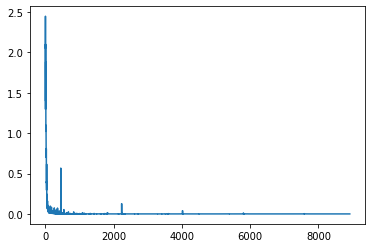

In [ ]:
# Creating the environment
env = gym.make('CartPole-v0')

# Defining the parameters
state_dim = 4
action_dim = 1

input_size = state_dim + action_dim
output_size = state_dim
num_hidden = 2
hidden_size = 50

# Creating the predictor model
state_predictor = MLP(input_size, output_size, num_hidden, hidden_size)

# Creating the optmiizer
optimiser = optim.Adam(state_predictor.parameters())

# Training loop
num_epochs = 5
losses = []
for epochs in range(num_epochs):
    print("Epoch:", epochs, "of", num_epochs)
    for batch_idx in range(num_batches):

        inputs = batched_state_action[batch_idx] # Input of the model for this batch
        targets = batched_next_state[batch_idx] # Target output of the model for this batch

        optimiser.zero_grad()

        loss = MSE_loss(state_predictor(inputs), targets)

        loss.backward()
        optimiser.step()

        losses.append(loss.item())

# Closing the environment
env.close()

# Plot the loss across training
plt.plot(losses)

In [ ]:
# Displaying the learned model dynamics in the CartPole environment

# simulated_env allows us to visualise the learned model dynamics
# by calling simulated_env.set_next_state(next_state) we set the expected
# next_state and we can visualise what the learned dynamics looks like
# video saved in the 'learned_dynamics' folder
simulated_env = TimeLimit(ShowCartPolePredictions(), max_episode_steps=500)
simulated_env = Monitor(simulated_env, './learned_dynamics', force=True)

#Performing the episode
state = simulated_env.reset()
done = False
state = torch.tensor(simulated_env.state).float()

while not done:

    # Predict the state with the model
    action = torch.tensor([simple_policy(state, p_random)])
    state_action = torch.cat((state, action))
    with torch.no_grad():
        predicted_state = state_predictor(state_action)
        predicted_state = list([float(s) for s in predicted_state.squeeze()])

    # Apply it in the environment
    state, reward, done, info = simulated_env.step(predicted_state)
    state = torch.tensor(simulated_env.state).float()

simulated_env.close()

### Question 6: Trying multiple loss functions

In [ ]:
# Alternative loss function

def L1_loss(prediction, target):
  """ 
  L1 loss function.
  Input:
    - prediction {torch.tensor} - target
    - target {torch.tensor} - model prediction
  Output: loss {float} - L1 error between the prediction and the target 
  """
  return (abs(prediction - target)).sum()

In [ ]:
## Torch MSE loss function
torch_MSE_loss = nn.MSELoss()

# You can call it the same way you would do with our hand design loss:
inputs = batched_state_action[0] # Input of the model for this batch
targets = batched_next_state[0] # Target output of the model for this batch
loss = torch_MSE_loss(state_predictor(inputs), targets)
print(loss)

## Torch L1 loss function
torch_L1_loss = nn.L1Loss()

# You can call it the same way you would do with our hand design loss:
inputs = batched_state_action[0] # Input of the model for this batch
targets = batched_next_state[0] # Target output of the model for this batch
loss = torch_L1_loss(state_predictor(inputs), targets)
print(loss)

## Torch Huber loss function
torch_Huber_loss = nn.HuberLoss()

# You can call it the same way you would do with our hand design loss:
inputs = batched_state_action[0] # Input of the model for this batch
targets = batched_next_state[0] # Target output of the model for this batch
loss = torch_Huber_loss(state_predictor(inputs), targets)
print(loss)

tensor(8.5933e-06, grad_fn=<MseLossBackward>)
tensor(0.0022, grad_fn=<L1LossBackward>)
tensor(4.2966e-06, grad_fn=<HuberLossBackward>)
